In [90]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
df = pd.read_csv("CHF=X.csv")

#data cleaning & processing 
df.Date = pd.to_datetime(df.Date)
df = df.fillna(method="pad", limit=1)

NB_TEST = int(0.2*len(df))
for i in df.columns[1:]:
  df[i] = pd.to_numeric(df[i])
print(f'Nb Nan: {df.Close.isnull().sum()}')
print(f'Columns name: {df.columns.values}')


Nb Nan: 0
Columns name: ['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']


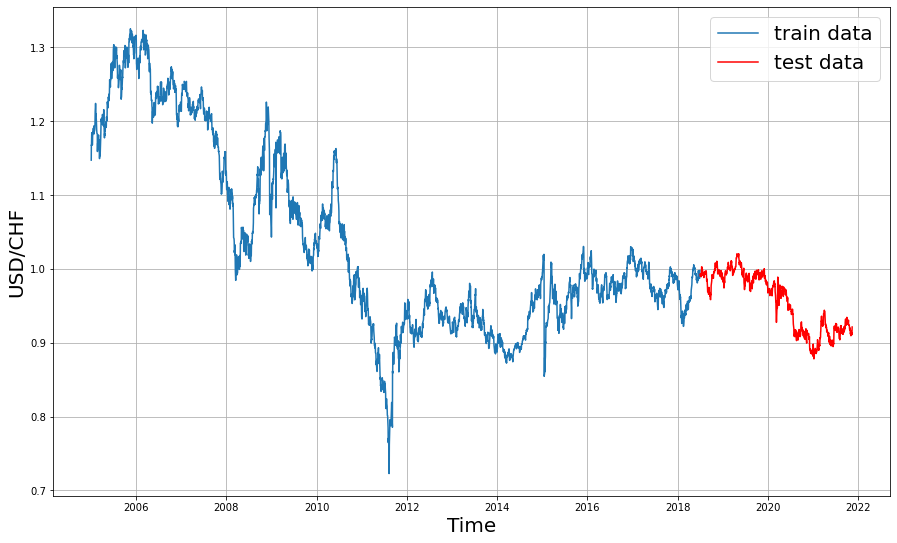

In [92]:
plt.figure(figsize=(15, 9))
plt.plot(df.Date.values[:-NB_TEST],df.Close.values[:-NB_TEST], label="train data")
plt.plot(df.Date.values[-NB_TEST:], df.Close.values[-NB_TEST:], color="r", label="test data")
plt.xlabel("Time", fontsize=20)
plt.ylabel("USD/CHF", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [93]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

LOOKBACK = 10
NORM = False


train_x = []
train_y = []
test_x = []
test_y = []

inputs = np.zeros((len(df)-LOOKBACK, LOOKBACK))
labels = np.zeros((len(df)-LOOKBACK, 1))
for i in range(LOOKBACK, len(df)):
    inputs[i-LOOKBACK] = df.Close.iloc[i-LOOKBACK:i].values
    labels[i-LOOKBACK] = df.Close.iloc[i]

# Split data into train and test
train_x = inputs[:-NB_TEST]
train_y = labels[:-NB_TEST]
test_x = inputs[-NB_TEST:]
test_y = labels[-NB_TEST:]

MM = MinMaxScaler()
SS = StandardScaler()

if NORM:
  train_x = MM.fit_transform(train_x)
  train_y = SS.fit_transform(train_y)

  test_x = MM.transform(test_x)
  test_y = SS.transform(test_y)

train_x = train_x.reshape(-1,LOOKBACK, 1)
test_x = test_x.reshape(-1,LOOKBACK, 1)

train_x, train_x_val, train_y, train_y_val =  train_test_split(train_x, train_y, test_size=0.2, shuffle=False) #random_state=0

print(f'Shape: X train {train_x.shape} y train {train_y.shape}; X train val {train_x_val.shape} y train {train_y_val.shape} val ;  X test {test_x.shape}  y test{test_y.shape}')

Shape: X train (2808, 10, 1) y train (2808, 1); X train val (702, 10, 1) y train (702, 1) val ;  X test (880, 10, 1)  y test(880, 1)


In [6]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, BatchNormalization, Conv1D, Flatten, LSTM, RNN
import tensorflow as tf

In [8]:
result = pd.DataFrame()
EPOCHS = 800
BATCH_SIZE = 512

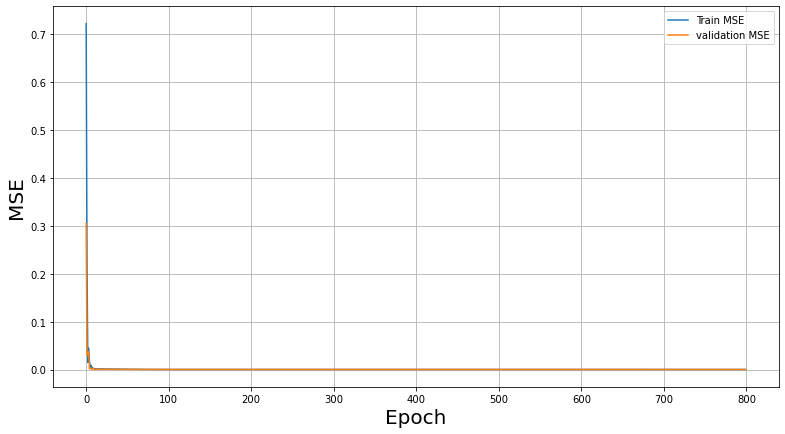

790    0.000077
791    0.000077
792    0.000077
793    0.000078
794    0.000078
795    0.000084
796    0.000084
797    0.000079
798    0.000081
799    0.000080
Name: MSE_train_GRU_Net, dtype: float64 0      0.304931
1      0.028808
2      0.032824
3      0.037318
4      0.001224
         ...   
795    0.000042
796    0.000034
797    0.000033
798    0.000036
799    0.000029
Name: MSE_val_GRU_Net, Length: 800, dtype: float64
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [13]:
GRU_Net = Sequential()

GRU_Net.add(GRU(units=64, input_shape=(train_x.shape[1],1)))
GRU_Net.add(Dense(1, activation='linear'))

GRU_Net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

hist = GRU_Net.fit(train_x, train_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(train_x_val, train_y_val))

result['MSE_train_GRU_Net'] = hist.history['mean_squared_error']
result['MSE_val_GRU_Net'] = hist.history['val_mean_squared_error']

fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_GRU_Net'], label='Train MSE')
plt.plot(result['MSE_val_GRU_Net'] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()
print(result['MSE_train_GRU_Net'][-10:], result['MSE_val_GRU_Net'])


GRU_Net.summary()

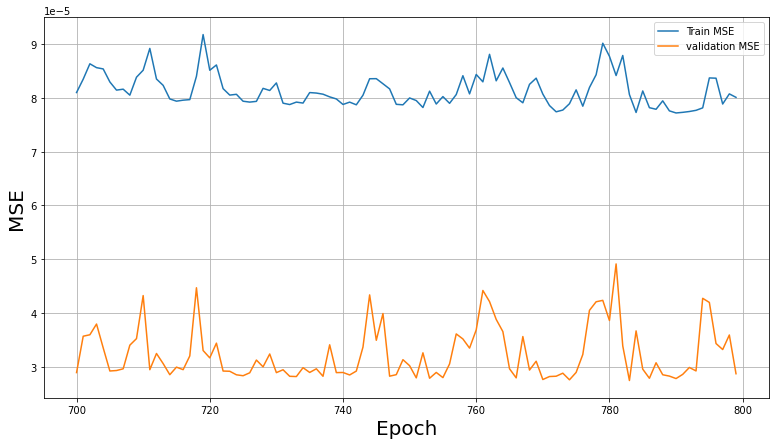

In [14]:
fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_GRU_Net'][-100:], label='Train MSE')
plt.plot(result['MSE_val_GRU_Net'][-100:] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()

In [94]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import tqdm 

In [121]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [149]:
class GRU_v0(nn.Module):
    def __init__(self, hidden_size= 32, num_layers= 1):
        super(GRU_v0, self).__init__()

        self.input_size = 1 #input size
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #GRU
        self.fc_1 =  nn.Linear(self.hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, 1) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state

        # Propagate input through GRU
        output, hn = self.gru(x, h_0) #GRU with input, hidden, and internal state
        
        hn = hn[-1].view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [150]:
gru = GRU_v0()
hidden_size= 64
num_layers= 5
gru_augmented = GRU_v0(hidden_size, num_layers)
model = [ gru_augmented,gru]
print(model)

[GRU_v0(
  (gru): GRU(1, 64, num_layers=5, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), GRU_v0(
  (gru): GRU(1, 32, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)]


In [152]:
for m in model:
  device = 'cpu'
  num_epochs = 2000
  criterion = nn.MSELoss()   
  optimizer = torch.optim.Adam(m.parameters(), lr=0.001) 

  for epoch in tqdm.tqdm(range(num_epochs)):
    avg_loss = 0.
    for x, label in train_loader:
      outputs = m(x.to(device).float())
      
      optimizer.zero_grad()
      loss = criterion(outputs, label.to(device).float())
      loss.backward()
      optimizer.step()
      avg_loss += loss.item()
  if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, avg_loss/len(train_loader))) 

100%|██████████| 2000/2000 [01:56<00:00, 17.19it/s]


In [109]:
def evaluate(model, x_, y_):
    model.eval()

    outputs = []
    targets = []
    
    inp = torch.from_numpy(np.array(x_))
    labs = torch.from_numpy(np.array(y_))

    out = model(inp.to(device).float())
    outputs = out.cpu().detach().numpy()
    targets = labs.numpy().reshape(-1)

    MSE = np.mean((outputs-targets)**2)
    print("MSE: {}%".format(MSE*100))
    return outputs, targets, MSE

In [119]:
outputs, targets, sMAPE = evaluate(gru, train_x_val, train_y_val)
outputs2 = GRU_Net.predict(train_x_val)
print(f"MSE (tf): { np.mean((outputs2-targets)**2)*100}%")

MSE: 0.08686481336303213%
MSE (tf): 0.08659330416310411%


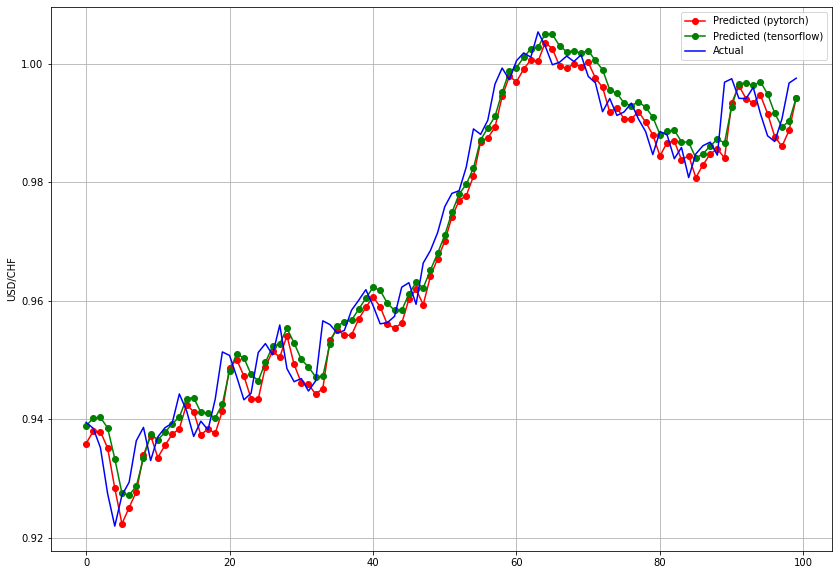

In [115]:
plt.figure(figsize=(14,10))

plt.plot(outputs[-100:], "-o", color="r", label="Predicted (pytorch)")
plt.plot(outputs2[-100:], "-o", color="g", label="Predicted (tensorflow)")
plt.plot(targets[-100:], color="b", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()
